## Домашнее задание : "Обучение с подкреплением"

ФИО: Мушенко Егор Сергеевич

# Задание 1

Обучите алгоритм Q-learning для сред FrozenLake-v1 и Blackjack-v1, в частности подберите оптимальную alpha. (1 балл)

In [1]:
#!pip install ale-py
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!pip uninstall gym -y
!pip install gym
#!pip uninstall ale-py -y
!pip install ale-py
!pip install "gym[toy_text]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gym
import numpy as np

env_fl = gym.make('FrozenLake-v1')
env_bj = gym.make('Blackjack-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
num_states_fl = env_fl.observation_space.n
num_actions_fl = env_fl.action_space.n
Q_fl = np.zeros((num_states_fl, num_actions_fl))
Q_fl = Q_fl.astype(int)
num_states_bj = 200 
num_actions_bj = 2
Q_bj = np.zeros((num_states_bj, num_actions_bj))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def q_learning(env, Q, alpha=0.1, gamma=0.99, epsilon=0.1, episodes=1000):
    '''Обучение Q-learning на заданной среде.'''
    rewards = []

    for i in range(episodes):
        s = env.reset()
        done = False
        total_reward = 0
        Q = np.around(Q, decimals=1).astype(np.int32)
        while not done:
            # Выбираем действие с помощью e-greedy стратегии
            if np.random.random() < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s, :])

            # Выполняем действие и получаем новое состояние и вознаграждение
            s_new, r, done, _ = env.step(a)

            # Обновляем Q-таблицу
            Q[s, a] = Q[s, a] +(alpha * (r + gamma * np.max(Q[s_new, :]) - Q[s, a]))

            s, total_reward = s_new, total_reward + r

        rewards.append(total_reward)
    return Q, rewards

In [6]:
#!pip install inspect
from tqdm import tqdm
from inspect import currentframe, getframeinfo
frameinfo = getframeinfo(currentframe())
alphas = np.linspace(0.01, 0.99, 100)
Q_fl_results = []
Q_bj_results = []


for alpha in tqdm(alphas):
    #print("Line #" + str(frameinfo.lineno), alpha)
    Q_fl_optimal, rewards_fl = q_learning(env_fl, Q_fl.copy(), alpha=alpha)

    Q_fl_results.append(rewards_fl)

    Q_bj_optimal, rewards_bj = q_learning(env_bj, Q_bj.copy(), alpha=alpha)

    Q_bj_results.append(rewards_bj)


100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


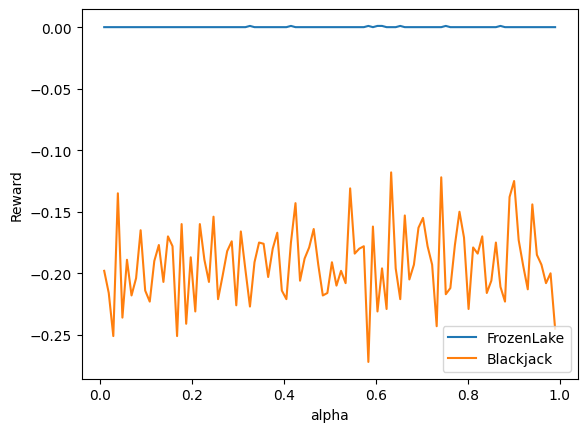

In [7]:
import matplotlib.pyplot as plt

plt.plot(alphas, np.mean(Q_fl_results, axis=1), label='FrozenLake')
plt.plot(alphas, np.mean(Q_bj_results, axis=1), label='Blackjack')
plt.xlabel('alpha')
plt.ylabel('Reward')
plt.legend()
plt.show()

# Задание 2

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (3 балла)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%pip install atari-py
!python -m atari_py.import_roms drive/MyDrive/Roms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
%pip install ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from ale_py import ALEInterface

ale = ALEInterface()

In [12]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install gym[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from ale_py.roms import Breakout

ale.loadROM(Breakout)

In [15]:
import torch
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
import gym
os.environ["SDL_VIDEODRIVER"] = "dummy"
#create a single game instance
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

#start new game
env.reset();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

In [17]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


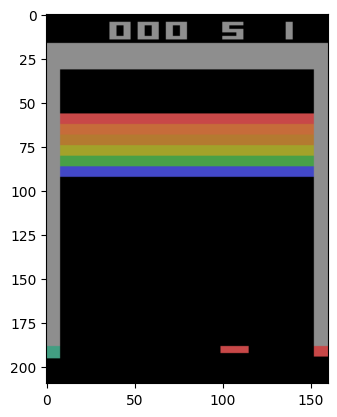

In [18]:
plt.imshow(env.render())

In [19]:
def preprocess(screen, width=env.observation_space.shape[0], height=env.observation_space.shape[1], targetWidth=84, targetHeight=84):
	# plt.imshow(screen)
	# plt.show()
	screen = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
	screen = screen[20:300, 0:200]  # crop off score
	screen = cv2.resize(screen, (targetWidth, targetHeight))
	screen = screen.reshape(targetWidth, targetHeight) / 255
	# plt.imshow(np.array(np.squeeze(screen)), cmap='gray')
	# plt.show()
	return screen

In [20]:
env.reset()
new_state, _, _, _ = env.step(1)[:4]

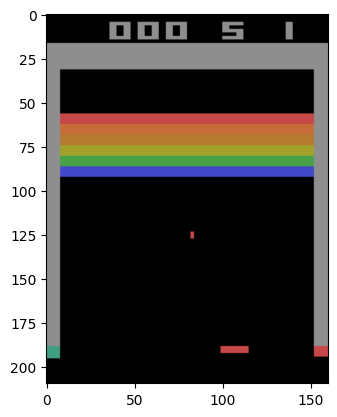

In [21]:
plt.imshow(new_state)

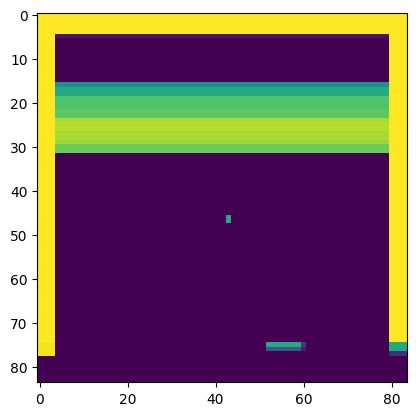

In [22]:
plt.imshow(preprocess(new_state))

In [23]:
import imageio

In [24]:
import os
folder_path = "/content/drive/MyDrive/atari/"
if not os.path.exists(folder_path):
  os.makedirs(folder_path)

In [25]:
def save_gif(state_list, gif_name):
    imageio.mimsave(
    f"drive/MyDrive/atari/{gif_name}.gif",
    state_list,
    fps=24,
)

In [26]:
def make_game(env, atari_nn, gif_name, max_repeat=2000):
    state = env.reset()[0]
    done = False
    renders = []
    i = 0
    repeat_cnt = 0
    env.step(1)[:4]

    for i in tqdm(range(max_repeat)):
        renders.append(env.render())
        state = torch.from_numpy(state).float()
        state = torch.moveaxis(state, 2, 0)
        action = atari_nn.get_next_state(state)
        if action is None:
            next_state, reward, done, _ = env.step(np.random.randint(0, 4))[:4]
            state = next_state
            continue

        next_state, reward, done, _ = env.step(action)[:4]
        if next_state == state:
            repeat_cnt += 1
        if done:
            break
        state = next_state
        i += 1
    save_gif(renders, gif_name)
    return renders

In [27]:
class AtariNet(torch.nn.Module):
    def __init__(self, gamma=0.9, loss_coeff=0.4, entropy_coeff=0.6):
        super(AtariNet, self).__init__()
        self.gamma = gamma
        self.loss_coeff = loss_coeff
        self.entropy_coeff = entropy_coeff
        self.action_probs = []
        self.rewards = []

        # 4 канала - 4 последовательных состояния игры
        self.convLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 8, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.convLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.convLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = torch.nn.Linear(2048, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 4)

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)
        x = x.flatten()
        x = torch.nn.ReLU()(self.fc1(x))
        x = torch.nn.ReLU()(self.fc2(x))
        x = torch.nn.Softmax()(self.fc3(x))
        return x
    
    def get_next_state(self, env_state):
        env_state = Variable(env_state)
        prob = self.forward(env_state)

        prob = torch.distributions.Categorical(prob) 
        action = prob.sample()
        self.action_probs.append(prob.log_prob(action))

        return action.item()

    def get_loss(self, rewards):
        policy_losses = torch.zeros(len(rewards))
    
        for i, log_prob, reward in zip(np.arange(len(rewards)), self.action_probs, rewards):
            policy_losses[i] = -log_prob*reward

        m = torch.distributions.Categorical(
        logits=torch.cat([x.view(-1) for x in self.action_probs]))
        entropy_loss = (-0.05 * m.entropy()).mean()
        return self.loss_coeff*policy_losses.sum() + self.entropy_coeff*entropy_loss

    def get_discounted_reward(self):

        discounted_reward = np.zeros_like(self.rewards)

        mediate_sum = 0
        for t in reversed(range(len(self.rewards))):
            mediate_sum = mediate_sum * self.gamma + self.rewards[t]
            discounted_reward[t] = mediate_sum

        return discounted_reward

In [28]:
def train(env, atari_nn, num_episodes=10, repeat_number = 2000):
    max_reward = -999
    batch_size = 5
    learning_rate = 0.05
    optimizer = torch.optim.Adam(atari_nn.parameters(), lr=learning_rate)
    episode_durations = []
    state_pool = []
    steps = 0

    for e in range(num_episodes):
        renders = []
        states = []
        state = env.reset()[0]
        state, reward, done, info = env.step(1)[:4]
        renders.append(env.render())
        state = torch.from_numpy(state).float()
        if state.__class__ != np.ndarray:
                state = state.numpy()
        state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
        states.append(state)
        # случайная генерация четырех первых состояний
        for i in range(3):
          state, reward, done, info = env.step(np.random.randint(0, 4))[:4]
          renders.append(env.render())
          state = torch.from_numpy(state).float()
          if state.__class__ != np.ndarray:
                  state = state.numpy()
          state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
          states.append(state)
        lives = 5

        for t in tqdm(range(repeat_number)):
            renders.append(env.render())
            action = atari_nn.get_next_state(torch.cat(states, 0))
            
            next_state, reward, done, info = env.step(action)[:4]
            if info['lives'] < lives:
                lives = info['lives']
                next_state, _, done, info = env.step(1)[:4]
            atari_nn.rewards.append(reward)
            state = next_state
            state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
            del states[0]
            states.append(state)
            if done:
                break
        episode_durations.append(t)

        if sum(atari_nn.rewards) > max_reward:
          max_reward = sum(atari_nn.rewards)
          save_gif(renders, f'best')
        if e%5 == 0:
          save_gif(renders, f'game_{e}')

        optimizer.zero_grad()
        loss = atari_nn.get_loss(atari_nn.get_discounted_reward())
        loss.backward()
            
        optimizer.step()

        # clear_output()
        print(f'Iteration: {e}; rewards={sum(atari_nn.rewards)}, loss={loss.item()}')
        atari_nn.rewards = []
        atari_nn.action_probs = []

    return episode_durations

In [29]:
net = AtariNet(loss_coeff=0.9, entropy_coeff=1.2)

In [30]:
episode_durations = train(env, net, num_episodes=50)

  0%|          | 0/2000 [00:00<?, ?it/s]

<ipython-input-34-d7307400e145>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.Softmax()(self.fc3(x))


Iteration: 0; rewards=2.0, loss=24.154144287109375


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 1; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 2; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 3; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 4; rewards=3.0, loss=-0.32883521914482117


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 5; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 6; rewards=3.0, loss=-0.3288351893424988


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 7; rewards=2.0, loss=-0.3154476284980774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 8; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 9; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 10; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 11; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 12; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 13; rewards=3.0, loss=-0.3288351893424988


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 14; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 15; rewards=3.0, loss=-0.32883521914482117


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 16; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 17; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 18; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 19; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 20; rewards=3.0, loss=-0.3288351893424988


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 21; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 22; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 23; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 24; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 25; rewards=2.0, loss=-0.3154476284980774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 26; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 27; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 28; rewards=3.0, loss=-0.3288351893424988


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 29; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 30; rewards=3.0, loss=-0.32883521914482117


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 31; rewards=2.0, loss=-0.3154476284980774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 32; rewards=2.0, loss=-0.3154476284980774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 33; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 34; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 35; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 36; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 37; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 38; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 39; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 40; rewards=4.0, loss=-0.3399813771247864


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 41; rewards=2.0, loss=-0.3154476284980774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 42; rewards=4.0, loss=-0.3399813771247864


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 43; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 44; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 45; rewards=2.0, loss=-0.3154476284980774


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 46; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 47; rewards=0.0, loss=-0.2857305109500885


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 48; rewards=2.0, loss=-0.315447598695755


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 49; rewards=2.0, loss=-0.315447598695755


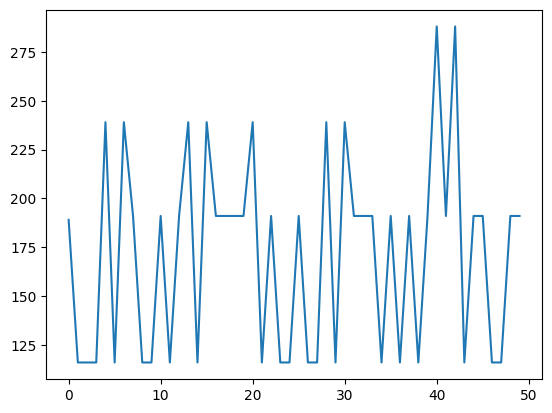

In [31]:
plt.plot(episode_durations)